In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd

In [3]:
import warnings 

warnings.filterwarnings('ignore')

# <center>Computational Mathematics Report Experiments</center>
## <center>Support Vector Classifier</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group 35</center>

In [4]:
def filter_svc_cv_results(cv_results):
    
    filtered_cv_results = pd.DataFrame()
    
    if 'param_optimizer' in cv_results.columns:
        
        filtered_cv_results['solver'] = cv_results['param_optimizer']
    
    if 'param_momentum_type' in cv_results.columns:
        filtered_cv_results['momentum'] = cv_results['param_momentum_type']
    
    if 'param_kernel' in cv_results.columns:
        
        filtered_cv_results['kernel'] = cv_results['param_kernel']
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*PolyKernel.*$)', 'poly')
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*GaussianKernel.*$)', 'rbf')
    
    filtered_cv_results[['C', 'fit_time', 
                         'train_accuracy', 'val_accuracy']] = cv_results[['param_C', 'mean_fit_time', 
                                                                          'mean_train_accuracy', 'mean_test_accuracy']]
    
    if 'mean_train_n_iter' in cv_results.columns:
        filtered_cv_results['n_iter'] = cv_results['mean_train_n_iter'].round().astype(int)
    
    filtered_cv_results['train_n_sv'] = cv_results['mean_train_n_sv'].round().astype(int)
    filtered_cv_results['val_n_sv'] = cv_results['mean_test_n_sv'].round().astype(int)

    return filtered_cv_results

## Hinge loss

### Primal formulation

In [9]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import hinge
from optiml.ml.utils import generate_linearly_separable_overlap_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.svm import LinearSVC as SkLinearSVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [36]:
def primal_accuracy_scorer(svc, X, y):
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SkLinearSVC) else svc.optimizer.iter, 
            'n_sv': len(np.argwhere(np.abs(svc.decision_function(X)) <= 1).ravel())}

Fitting 3 folds for each of 3 candidates, totalling 9 fits


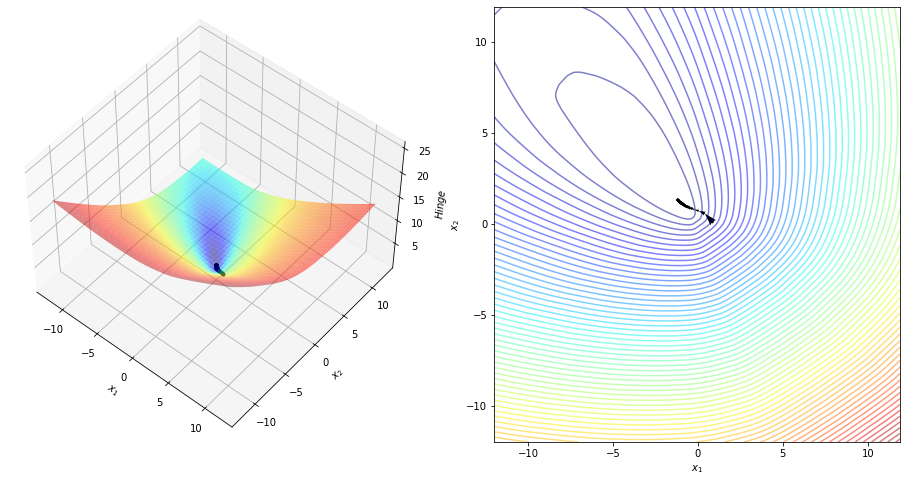

In [53]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(PrimalSVC(loss=hinge, optimizer=AdaGrad, learning_rate=0.5, 
                              max_iter=1000, early_stopping=True, patience=5),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_trajectory_optimization(grid.best_estimator_.loss, grid.best_estimator_.optimizer, 
                             x_min=-12, x_max=12, y_min=-12, y_max=12)
plt.savefig('./tex/img/svc_hinge_loss.png')

In [54]:
custom_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
custom_primal_svc_hinge_cv_results.insert(0, 'solver', 'adagrad')
custom_primal_svc_hinge_cv_results.style.hide_index()

solver,C,fit_time,train_accuracy,val_accuracy,n_iter,nr_train_sv,nr_val_sv
adagrad,1,0.151886,0.972506,0.975049,73,15,8
adagrad,10,0.300753,0.980025,0.970074,229,10,5
adagrad,100,0.374231,0.977518,0.975049,491,9,4


In [55]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(SkLinearSVC(loss='hinge'),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [56]:
liblinear_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svc_hinge_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svc_hinge_cv_results.style.hide_index()

solver,C,fit_time,train_accuracy,val_accuracy,n_iter,nr_train_sv,nr_val_sv
liblinear,1,0.001718,0.985000,0.974974,125,12,7
liblinear,10,0.002889,0.982494,0.979949,443,8,5
liblinear,100,0.003613,0.985000,0.984999,829,6,4


In [57]:
primal_svc_hinge_cv_results = custom_primal_svc_hinge_cv_results.append(liblinear_primal_svc_hinge_cv_results, ignore_index=True)
primal_svc_hinge_cv_results.sort_values(['C', 'solver'], inplace=True)
primal_svc_hinge_cv_results.to_latex('./tex/experiments/primal_svc_hinge.tex', index=False)
primal_svc_hinge_cv_results.style.hide_index()

solver,C,fit_time,train_accuracy,val_accuracy,n_iter,nr_train_sv,nr_val_sv
adagrad,1,0.151886,0.972506,0.975049,73,15,8
liblinear,1,0.001718,0.985000,0.974974,125,12,7
adagrad,10,0.300753,0.980025,0.970074,229,10,5
liblinear,10,0.002889,0.982494,0.979949,443,8,5
adagrad,100,0.374231,0.977518,0.975049,491,9,4
liblinear,100,0.003613,0.985000,0.984999,829,6,4


### Dual formulations

In [13]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.kernels import linear, PolyKernel, GaussianKernel
from optiml.ml.utils import generate_linearly_separable_overlap_data, generate_nonlinearly_separable_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [10]:
import re
from io import StringIO
from wurlitzer import pipes, STDOUT


class SklSVC(SVC):

    def fit(self, X, y, sample_weight=None):
        out = StringIO()
        with pipes(stdout=out, stderr=STDOUT):
            super().fit(X, y, sample_weight)
        self.n_iter_ = int(re.findall(r'%s(\d+)' % '#iter = ', out.getvalue())[0])

In [35]:
def dual_accuracy_scorer(svc, X, y):
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SVC) else (0 if isinstance(svc.optimizer, str)
                                                                else svc.optimizer.iter), 
            'n_sv': len(svc.support_)}

#### Wolfe Dual

##### Linear

Fitting 3 folds for each of 6 candidates, totalling 18 fits


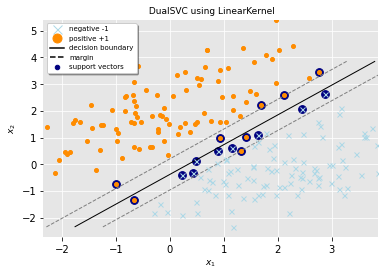

In [40]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(DualSVC(kernel=linear),
                    param_grid={'C': [1, 10, 100],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/linear_dual_svc_hyperplane.png')

In [47]:
custom_linear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
custom_linear_dual_svc_cv_results['n_iter'].replace(0, '-', inplace=True)
custom_linear_dual_svc_cv_results.style.hide_index()

solver,C,fit_time,train_accuracy,val_accuracy,n_iter,nr_train_sv,nr_val_sv
smo,1,0.053503,0.984981,0.984924,57,13,13
cvxopt,1,0.015307,0.984981,0.984924,-,13,13
smo,10,0.077646,0.984962,0.979873,77,8,8
cvxopt,10,0.026810,0.984962,0.979873,-,8,8
smo,100,0.345623,0.979987,0.974898,1093,6,6
cvxopt,100,0.014654,0.984962,0.979873,-,8,8


In [48]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(SklSVC(kernel='linear', verbose=True),  # `verbose=True` to capture n_iter
                    param_grid={'C': [1, 10, 100]},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[LibSVM]

In [49]:
libsvm_linear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_linear_dual_svc_cv_results.insert(0, 'solver', 'libsvm')
libsvm_linear_dual_svc_cv_results.style.hide_index()

solver,C,fit_time,train_accuracy,val_accuracy,n_iter,nr_train_sv,nr_val_sv
libsvm,1,0.004519,0.985019,0.985075,46,12,12
libsvm,10,0.003364,0.985019,0.985075,4224,9,9
libsvm,100,0.004929,0.985019,0.970149,11324,7,7


In [50]:
linear_dual_svc_cv_results = custom_linear_dual_svc_cv_results.append(libsvm_linear_dual_svc_cv_results, ignore_index=True)
linear_dual_svc_cv_results.sort_values(['C', 'solver'], inplace=True)
linear_dual_svc_cv_results.to_latex('./tex/experiments/linear_dual_svc.tex', index=False)
linear_dual_svc_cv_results.style.hide_index()

solver,C,fit_time,train_accuracy,val_accuracy,n_iter,nr_train_sv,nr_val_sv
cvxopt,1,0.015307,0.984981,0.984924,-,13,13
libsvm,1,0.004519,0.985019,0.985075,46,12,12
smo,1,0.053503,0.984981,0.984924,57,13,13
cvxopt,10,0.026810,0.984962,0.979873,-,8,8
libsvm,10,0.003364,0.985019,0.985075,4224,9,9
smo,10,0.077646,0.984962,0.979873,77,8,8
cvxopt,100,0.014654,0.984962,0.979873,-,8,8
libsvm,100,0.004929,0.985019,0.970149,11324,7,7
smo,100,0.345623,0.979987,0.974898,1093,6,6


##### Nonlinear

Fitting 3 folds for each of 6 candidates, totalling 18 fits


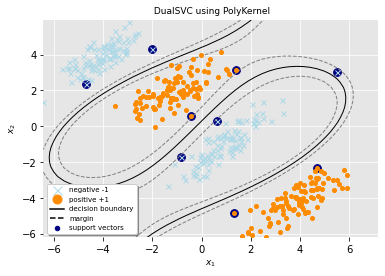

In [51]:
X, y = generate_nonlinearly_separable_data()

grid = GridSearchCV(DualSVC(),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/poly_dual_svc_hyperplane.png')

In [53]:
poly_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
poly_nonlinear_dual_svc_cv_results['n_iter'].replace(0, '-', inplace=True)
poly_nonlinear_dual_svc_cv_results.style.hide_index()

solver,kernel,C,fit_time,train_accuracy,val_accuracy,n_iter,nr_train_sv,nr_val_sv
smo,poly,1,1.453923,0.838745,0.693674,656,24,24
cvxopt,poly,1,0.099338,0.841242,0.693674,-,24,24
smo,poly,10,1.736367,0.897553,0.700258,1128,9,9
cvxopt,poly,10,0.070876,0.897553,0.697752,-,9,9
smo,poly,100,1.349979,0.944984,0.750327,1146,8,8
cvxopt,poly,100,0.065684,0.951217,0.725470,-,9,9


Fitting 3 folds for each of 6 candidates, totalling 18 fits


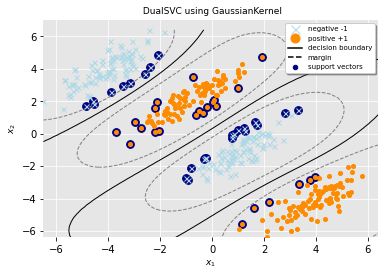

In [54]:
X, y = generate_nonlinearly_separable_data()

grid = GridSearchCV(DualSVC(),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [GaussianKernel(gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/gaussian_dual_svc_hyperplane.png')

In [55]:
rbf_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
rbf_nonlinear_dual_svc_cv_results['n_iter'].replace(0, '-', inplace=True)
rbf_nonlinear_dual_svc_cv_results.style.hide_index()

solver,kernel,C,fit_time,train_accuracy,val_accuracy,n_iter,nr_train_sv,nr_val_sv
smo,rbf,1,0.242894,1.000000,1.000000,35,44,44
cvxopt,rbf,1,0.075327,1.000000,1.000000,-,47,47
smo,rbf,10,0.371019,1.000000,1.000000,80,15,15
cvxopt,rbf,10,0.073975,1.000000,1.000000,-,17,17
smo,rbf,100,0.285135,1.000000,1.000000,100,13,13
cvxopt,rbf,100,0.082484,1.000000,1.000000,-,13,13


In [56]:
custom_nonlinear_dual_svc_cv_results = poly_nonlinear_dual_svc_cv_results.append(rbf_nonlinear_dual_svc_cv_results, ignore_index=True)
custom_nonlinear_dual_svc_cv_results.sort_values(['C', 'kernel', 'solver'], inplace=True)
custom_nonlinear_dual_svc_cv_results.style.hide_index()

solver,kernel,C,fit_time,train_accuracy,val_accuracy,n_iter,nr_train_sv,nr_val_sv
cvxopt,poly,1,0.099338,0.841242,0.693674,-,24,24
smo,poly,1,1.453923,0.838745,0.693674,656,24,24
cvxopt,rbf,1,0.075327,1.000000,1.000000,-,47,47
smo,rbf,1,0.242894,1.000000,1.000000,35,44,44
cvxopt,poly,10,0.070876,0.897553,0.697752,-,9,9
smo,poly,10,1.736367,0.897553,0.700258,1128,9,9
cvxopt,rbf,10,0.073975,1.000000,1.000000,-,17,17
smo,rbf,10,0.371019,1.000000,1.000000,80,15,15
cvxopt,poly,100,0.065684,0.951217,0.725470,-,9,9
smo,poly,100,1.349979,0.944984,0.750327,1146,8,8


In [57]:
X, y = generate_nonlinearly_separable_data()

grid = GridSearchCV(SklSVC(verbose=True),  # `verbose=True` to capture n_iter
                    param_grid=[{'C': [1, 10, 100],
                                 'kernel': ['poly'],
                                 'degree': [3],
                                 'coef0': [3],
                                 'gamma': ['scale']},
                                {'C': [1, 10, 100],
                                 'kernel': ['rbf'],
                                 'gamma': ['scale']}],
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[LibSVM]

In [58]:
libsvm_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_nonlinear_dual_svc_cv_results.insert(0, 'solver', 'libsvm')
libsvm_nonlinear_dual_svc_cv_results.style.hide_index()

solver,kernel,C,fit_time,train_accuracy,val_accuracy,n_iter,nr_train_sv,nr_val_sv
libsvm,poly,1,0.011390,1.000000,0.997494,1098,25,25
libsvm,poly,10,0.014845,1.000000,0.980025,1550,9,9
libsvm,poly,100,0.010411,1.000000,0.977537,1884,7,7
libsvm,rbf,1,0.011853,1.000000,0.997512,78,42,42
libsvm,rbf,10,0.018238,1.000000,1.000000,188,14,14
libsvm,rbf,100,0.012703,1.000000,0.997494,241,11,11


In [59]:
nonlinear_dual_svc_cv_results = custom_nonlinear_dual_svc_cv_results.append(libsvm_nonlinear_dual_svc_cv_results, ignore_index=True)
nonlinear_dual_svc_cv_results.sort_values(['C', 'kernel', 'solver'], inplace=True)
nonlinear_dual_svc_cv_results.to_latex('./tex/experiments/nonlinear_dual_svc.tex', index=False)
nonlinear_dual_svc_cv_results.style.hide_index()

solver,kernel,C,fit_time,train_accuracy,val_accuracy,n_iter,nr_train_sv,nr_val_sv
cvxopt,poly,1,0.099338,0.841242,0.693674,-,24,24
libsvm,poly,1,0.011390,1.000000,0.997494,1098,25,25
smo,poly,1,1.453923,0.838745,0.693674,656,24,24
cvxopt,rbf,1,0.075327,1.000000,1.000000,-,47,47
libsvm,rbf,1,0.011853,1.000000,0.997512,78,42,42
smo,rbf,1,0.242894,1.000000,1.000000,35,44,44
cvxopt,poly,10,0.070876,0.897553,0.697752,-,9,9
libsvm,poly,10,0.014845,1.000000,0.980025,1550,9,9
smo,poly,10,1.736367,0.897553,0.700258,1128,9,9
cvxopt,rbf,10,0.073975,1.000000,1.000000,-,17,17


#### Lagrangian Dual

##### Linear

In [37]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(DualSVC(kernel=linear, optimizer=AdaGrad, learning_rate=0.5, fit_intercept=True),
                    param_grid={'C': [1, 10, 100]},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [38]:
linear_qp_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
linear_qp_lagrangian_dual_svc_cv_results.insert(0, 'ld', 'qp')
linear_qp_lagrangian_dual_svc_cv_results.style.hide_index()

ld,C,fit_time,train_accuracy,val_accuracy,nr_train_sv,nr_val_sv
qp,1,0.013991,0.974993,0.980024,131,131
qp,10,0.013773,0.974993,0.980024,131,131
qp,100,0.016275,0.974993,0.980024,131,131


In [39]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(DualSVC(kernel=linear, optimizer=AdaGrad, learning_rate=0.5, fit_intercept=False),
                    param_grid={'C': [1, 10, 100]},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [40]:
linear_bcqp_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
linear_bcqp_lagrangian_dual_svc_cv_results.insert(0, 'ld', 'bcqp')
linear_bcqp_lagrangian_dual_svc_cv_results.style.hide_index()

ld,C,fit_time,train_accuracy,val_accuracy,nr_train_sv,nr_val_sv
bcqp,1,0.018653,0.992481,0.994949,127,127
bcqp,10,0.018454,0.992481,0.994949,127,127
bcqp,100,0.018384,0.992481,0.994949,127,127


In [41]:
linear_lagrangian_dual_svc_cv_results = linear_qp_lagrangian_dual_svc_cv_results.append(linear_bcqp_lagrangian_dual_svc_cv_results, ignore_index=True)
linear_lagrangian_dual_svc_cv_results.sort_values(['C', 'ld'], inplace=True)
linear_lagrangian_dual_svc_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_svc.tex', index=False)
linear_lagrangian_dual_svc_cv_results.style.hide_index()

ld,C,fit_time,train_accuracy,val_accuracy,nr_train_sv,nr_val_sv
bcqp,1,0.018653,0.992481,0.994949,127,127
qp,1,0.013991,0.974993,0.980024,131,131
bcqp,10,0.018454,0.992481,0.994949,127,127
qp,10,0.013773,0.974993,0.980024,131,131
bcqp,100,0.018384,0.992481,0.994949,127,127
qp,100,0.016275,0.974993,0.980024,131,131


##### Nonlinear

In [42]:
X, y = generate_nonlinearly_separable_data()

grid = GridSearchCV(DualSVC(optimizer=AdaGrad, learning_rate=0.5, fit_intercept=True),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='scale'), 
                                           GaussianKernel(gamma='scale')]},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [43]:
nonlinear_qp_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_qp_lagrangian_dual_svc_cv_results.insert(0, 'ld', 'qp')
nonlinear_qp_lagrangian_dual_svc_cv_results.style.hide_index()

ld,kernel,C,fit_time,train_accuracy,val_accuracy,nr_train_sv,nr_val_sv
qp,poly,1,0.737430,0.872504,0.750627,138,138
qp,rbf,1,1.608392,0.800071,0.635656,188,188
qp,poly,10,0.741292,0.872504,0.750627,138,138
qp,rbf,10,1.405860,0.857500,0.718400,199,199
qp,poly,100,0.571038,0.872504,0.750627,138,138
qp,rbf,100,0.761562,0.782584,0.608218,154,154


In [44]:
X, y = generate_nonlinearly_separable_data()

grid = GridSearchCV(DualSVC(optimizer=AdaGrad, learning_rate=0.5, fit_intercept=False),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='scale'), 
                                           GaussianKernel(gamma='scale')]},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [45]:
nonlinear_bcqp_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_bcqp_lagrangian_dual_svc_cv_results.insert(0, 'ld', 'bcqp')
nonlinear_bcqp_lagrangian_dual_svc_cv_results.style.hide_index()

ld,kernel,C,fit_time,train_accuracy,val_accuracy,nr_train_sv,nr_val_sv
bcqp,poly,1,0.078685,0.750007,0.501253,217,217
bcqp,rbf,1,0.028115,1.000000,0.997512,241,241
bcqp,poly,10,0.073986,0.750007,0.501253,217,217
bcqp,rbf,10,0.021263,1.000000,0.997512,241,241
bcqp,poly,100,0.063981,0.750007,0.501253,217,217
bcqp,rbf,100,0.025343,1.000000,0.997512,241,241


In [53]:
nonlinear_lagrangian_dual_svc_cv_results = nonlinear_qp_lagrangian_dual_svc_cv_results.append(nonlinear_bcqp_lagrangian_dual_svc_cv_results, ignore_index=True)
nonlinear_lagrangian_dual_svc_cv_results.sort_values(['C', 'kernel', 'ld'], inplace=True)
nonlinear_lagrangian_dual_svc_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_svc.tex', index=False)
nonlinear_lagrangian_dual_svc_cv_results.style.hide_index()

ld,kernel,C,fit_time,train_accuracy,val_accuracy,nr_train_sv,nr_val_sv
bcqp,poly,1,0.078685,0.750007,0.501253,217,217
qp,poly,1,0.737430,0.872504,0.750627,138,138
bcqp,rbf,1,0.028115,1.000000,0.997512,241,241
qp,rbf,1,1.608392,0.800071,0.635656,188,188
bcqp,poly,10,0.073986,0.750007,0.501253,217,217
qp,poly,10,0.741292,0.872504,0.750627,138,138
bcqp,rbf,10,0.021263,1.000000,0.997512,241,241
qp,rbf,10,1.405860,0.857500,0.718400,199,199
bcqp,poly,100,0.063981,0.750007,0.501253,217,217
qp,poly,100,0.571038,0.872504,0.750627,138,138


## Squared Hinge loss

### Primal formulation

In [7]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import squared_hinge
from optiml.ml.utils import generate_linearly_separable_overlap_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.svm import LinearSVC as SkLinearSVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [8]:
def primal_accuracy_scorer(svc, X, y):
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SkLinearSVC) else svc.optimizer.iter, 
            'n_sv': len(np.argwhere(np.abs(svc.decision_function(X)) <= 1).ravel())}

Fitting 3 folds for each of 9 candidates, totalling 27 fits


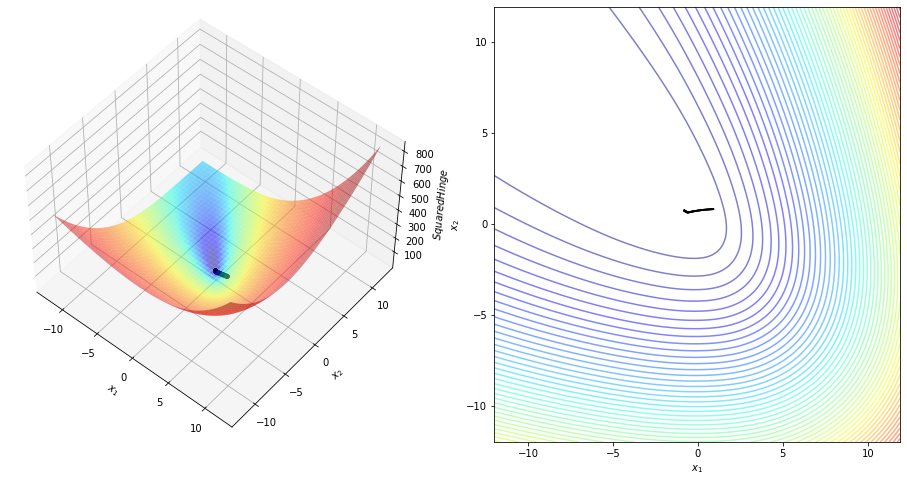

In [11]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(PrimalSVC(loss=squared_hinge, optimizer=StochasticGradientDescent, 
                              learning_rate=0.01, momentum=0.5, early_stopping=True, patience=5),
                    param_grid={'C': [1, 10, 100],
                                'momentum_type': ['none', 'standard', 'nesterov']},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_trajectory_optimization(grid.best_estimator_.loss, grid.best_estimator_.optimizer, 
                             x_min=-12, x_max=12, y_min=-12, y_max=12)
plt.savefig('./tex/img/svc_squared_hinge_loss.png')

In [12]:
custom_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
custom_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'sgd')
custom_primal_svc_squared_hinge_cv_results.style.hide_index()

solver,momentum_type,C,fit_time,train_accuracy,val_accuracy,n_iter,nr_train_sv,nr_val_sv
sgd,none,1,0.240039,0.970000,0.969998,130,28,14
sgd,standard,1,0.229616,0.970000,0.969998,102,26,12
sgd,nesterov,1,0.188692,0.970000,0.969998,117,24,13
sgd,none,10,0.039961,0.972487,0.969998,45,17,9
sgd,standard,10,0.022412,0.967493,0.969998,29,14,7
sgd,nesterov,10,0.029363,0.969981,0.969998,38,14,8
sgd,none,100,0.017605,0.972487,0.969998,20,9,5
sgd,standard,100,0.010095,0.969981,0.964948,9,3,2
sgd,nesterov,100,0.018532,0.974993,0.964948,26,5,2


In [13]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(SkLinearSVC(loss='squared_hinge'),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [14]:
liblinear_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svc_squared_hinge_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svc_squared_hinge_cv_results.style.hide_index()

solver,momentum_type,C,fit_time,train_accuracy,val_accuracy,n_iter,nr_train_sv,nr_val_sv
liblinear,-,1,0.004443,0.977481,0.979949,413,21,10
liblinear,-,10,0.006268,0.979969,0.974898,1000,17,7
liblinear,-,100,0.006951,0.979969,0.969923,1000,17,7


In [15]:
primal_svc_squared_hinge_cv_results = custom_primal_svc_squared_hinge_cv_results.append(liblinear_primal_svc_squared_hinge_cv_results, ignore_index=True)
primal_svc_squared_hinge_cv_results.sort_values(['C', 'solver'], inplace=True)
primal_svc_squared_hinge_cv_results.to_latex('./tex/experiments/primal_svc_squared_hinge.tex', index=False)
primal_svc_squared_hinge_cv_results.style.hide_index()

solver,momentum_type,C,fit_time,train_accuracy,val_accuracy,n_iter,nr_train_sv,nr_val_sv
liblinear,-,1,0.004443,0.977481,0.979949,413,21,10
sgd,none,1,0.240039,0.970000,0.969998,130,28,14
sgd,standard,1,0.229616,0.970000,0.969998,102,26,12
sgd,nesterov,1,0.188692,0.970000,0.969998,117,24,13
liblinear,-,10,0.006268,0.979969,0.974898,1000,17,7
sgd,none,10,0.039961,0.972487,0.969998,45,17,9
sgd,standard,10,0.022412,0.967493,0.969998,29,14,7
sgd,nesterov,10,0.029363,0.969981,0.969998,38,14,8
liblinear,-,100,0.006951,0.979969,0.969923,1000,17,7
sgd,none,100,0.017605,0.972487,0.969998,20,9,5
